In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# 0. Precurser Info
## 0.a Credits
* This is my first competition on Kaggle
* For resources, I used:
    * [Alexis Cook Titanic Tutoria Walkthrough](https://www.kaggle.com/code/alexisbcook/titanic-tutorial/notebook)
    * [Ken Jee Tutorial Video](https://www.youtube.com/watch?v=I3FBJdiExcg])
    * A numer of articles on stack overflow, kaggle, and some sparring with ChatGPT 4o in the moments where the logic / reasoning was not completely clear to me =)
## 0.b Variable Descriptions
* survival	Survival	0 = No, 1 = Yes
* pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
* sex	male, female
* Age	Age in years
* sibsp	# of siblings / spouses aboard the Titanic
* parch	# of parents / children aboard the Titanic
* ticket	Ticket number
* fare	Passenger fare
* cabin	Cabin number
* embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

## 0.b Additional Import Statements

In [2]:
from sklearn.ensemble import RandomForestClassifier #in order to use a random forest classification tree
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

# 1.a Import Training and Testing Data

In [3]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')
train_data.head() #just figured out that excluding the print statement shows a more legible than using the print() output

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 1.b Training Data Exploration

In [4]:
train_data.info()
#Age and Cabin have quite a few null values, and Embarked as 2 missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


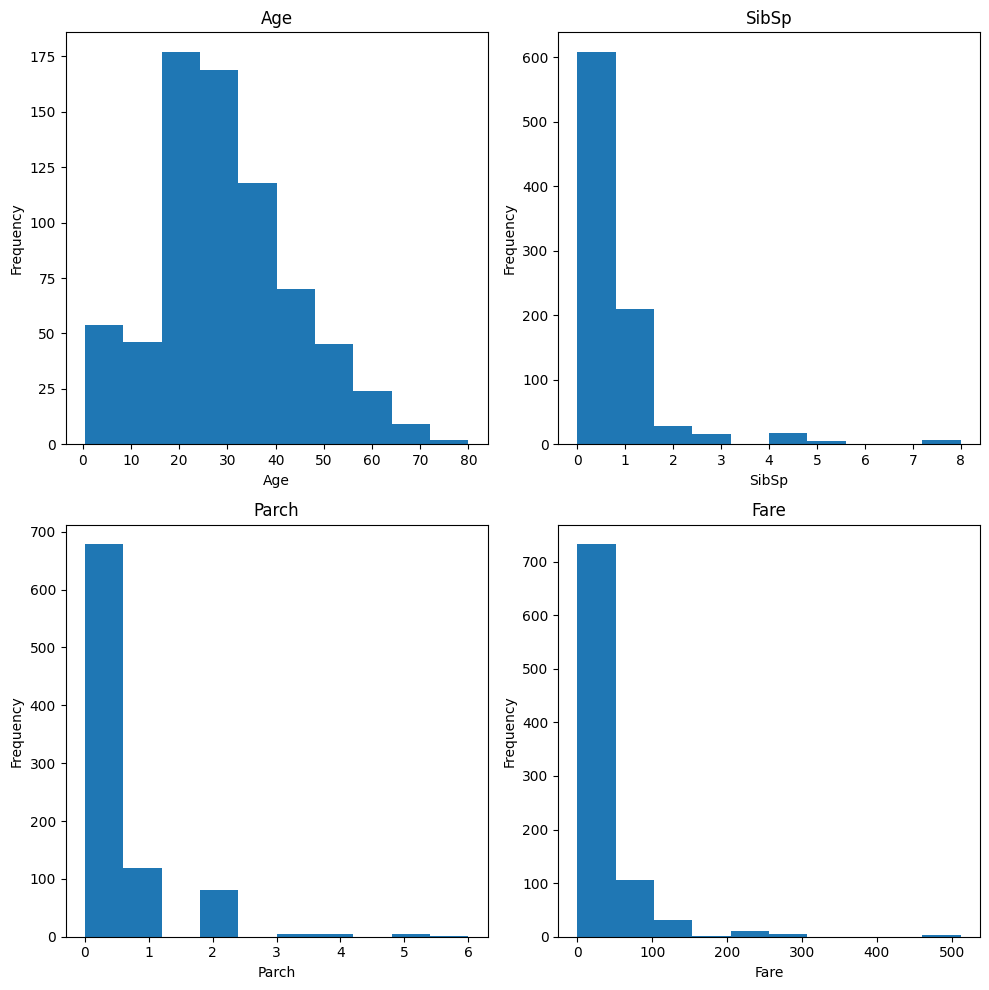

In [6]:
df_num = train_data[['Age', 'SibSp', 'Parch', 'Fare']]
df_cat = train_data[['Survived', 'Pclass', 'Sex', 'Ticket', 'Cabin', 'Embarked']]

fig, axes = plt.subplots(2,2,figsize=(10,10))
axes = axes.flatten()

for i, col in enumerate(df_num.columns):
    axes[i].hist(df_num[col].dropna())
    axes[i].set_title(col)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

            Age     SibSp     Parch      Fare
Age    1.000000 -0.308247 -0.189119  0.096067
SibSp -0.308247  1.000000  0.414838  0.159651
Parch -0.189119  0.414838  1.000000  0.216225
Fare   0.096067  0.159651  0.216225  1.000000


<Axes: >

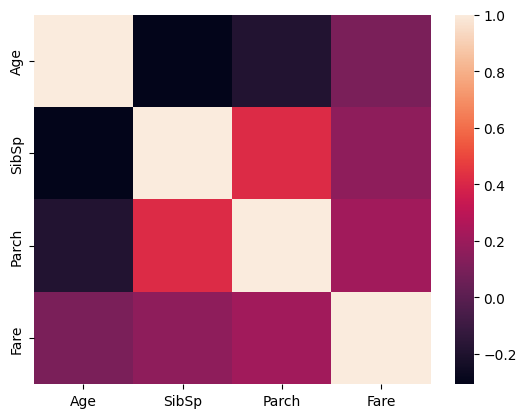

In [7]:
print(df_num.corr())
sns.heatmap(df_num.corr())

In [8]:
#Pivot table showing mean values for categories against Survival index
pd.pivot_table(train_data, index=['Survived'], values=['Age', 'SibSp', 'Parch', 'Fare'])

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


<Figure size 640x480 with 0 Axes>

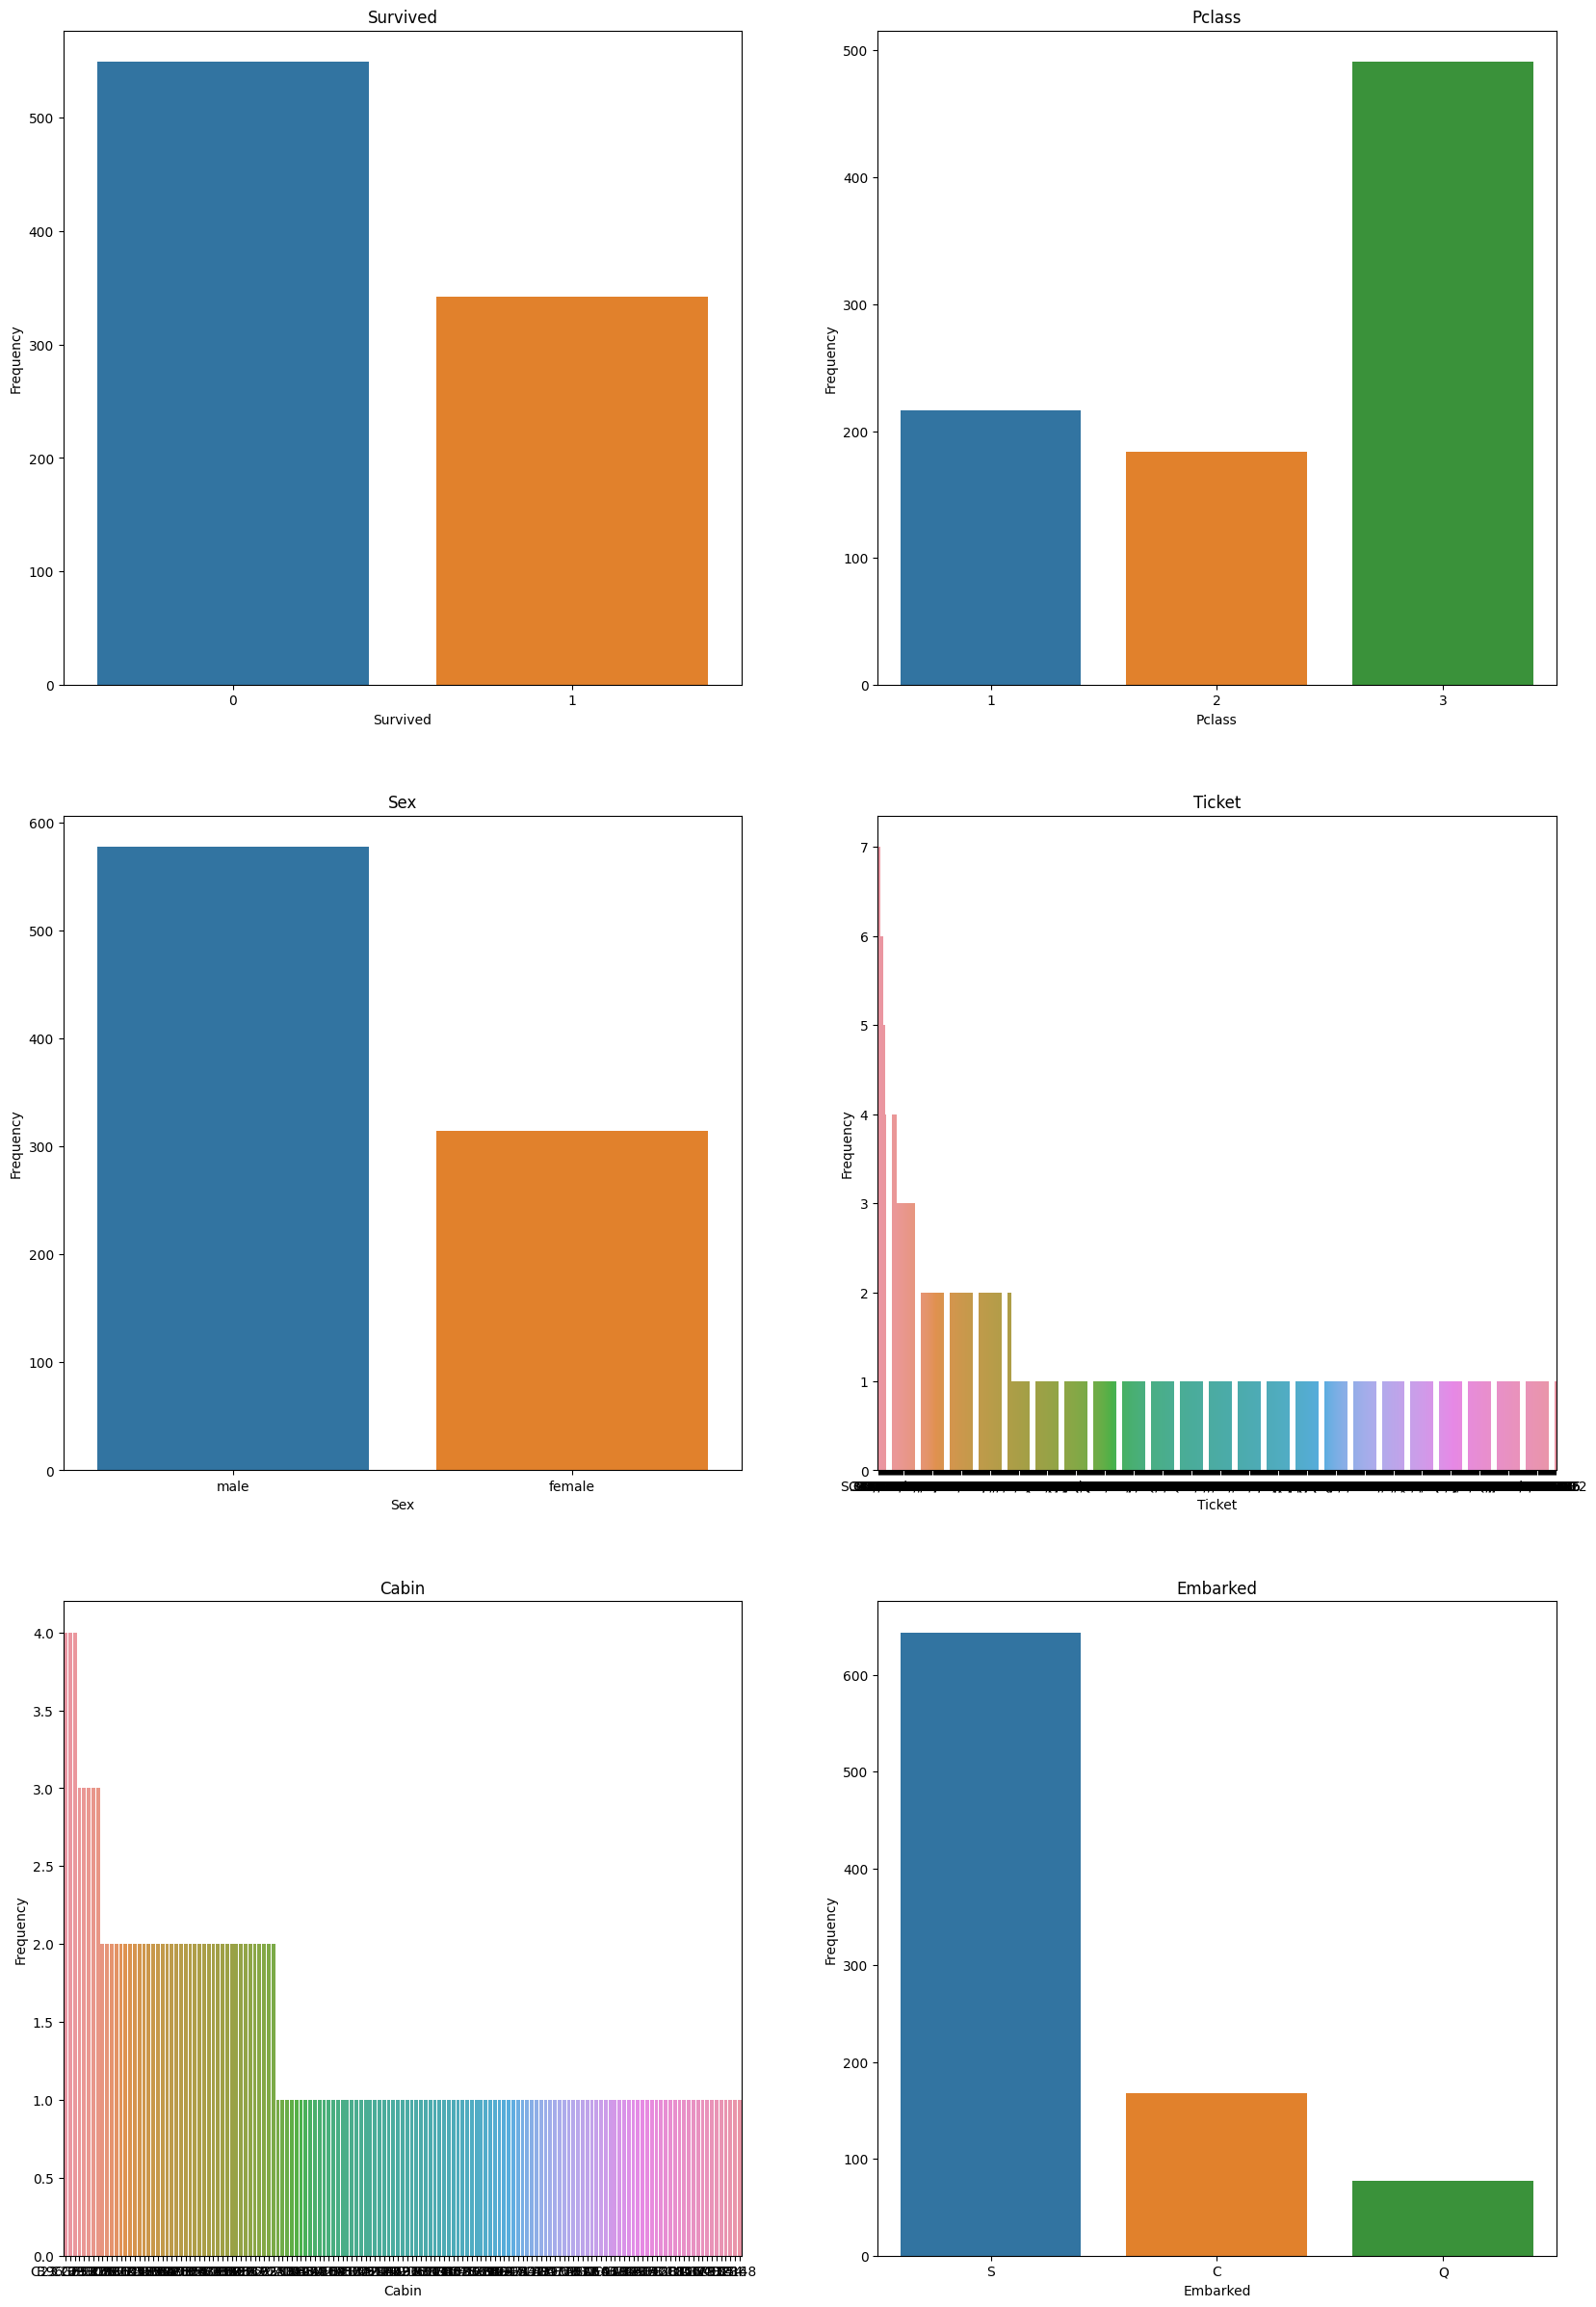

In [9]:
#Checking categorical variables for basic distribution
plt.clf()

fig, axes = plt.subplots(3,2,figsize=(20, 30))
axes = axes.flatten()

for i, col in enumerate(df_cat.columns):
    value_counts = df_cat[col].value_counts()
    value_counts_df = value_counts.reset_index()
    value_counts_df.columns = [col, 'Frequency']  # Rename columns for clarity
    
    sns.barplot(x=value_counts_df[col], y=value_counts_df['Frequency'], ax=axes[i])
    axes[i].set_title(col)  # Set title
    axes[i].set_xlabel(col)  # Set x-axis label
    axes[i].set_ylabel('Frequency')  # Set y-axis label

#plt.tight_layout()
plt.show()

In [10]:
#Pivot tables based on variables vs. survival rates (as percentage of total ticket count) to review if any parameters indicate a surival advantage

pclass_pivot = pd.pivot_table(train_data, index='Survived', columns='Pclass', values='Ticket', aggfunc='count', margins=True, margins_name='Total')
sex_pivot = pd.pivot_table(train_data, index='Survived', columns='Sex', values='Ticket', aggfunc='count', margins=True, margins_name='Total')
embarked_pivot = pd.pivot_table(train_data, index='Survived', columns='Embarked', values='Ticket', aggfunc='count', margins=True, margins_name='Total')

total_count = pclass_pivot.loc['Total', 'Total']

pclass_pivot_perc = (pclass_pivot / total_count * 100).round(1)
sex_pivot_perc = (sex_pivot / total_count * 100).round(1)
embarked_pivot_perc = (embarked_pivot / total_count * 100).round(1)

print(pclass_pivot_perc)
print()
print(sex_pivot_perc)
print()
print(embarked_pivot_perc)

Pclass       1     2     3  Total
Survived                         
0          9.0  10.9  41.8   61.6
1         15.3   9.8  13.4   38.4
Total     24.2  20.7  55.1  100.0

Sex       female  male  Total
Survived                     
0            9.1  52.5   61.6
1           26.2  12.2   38.4
Total       35.2  64.8  100.0

Embarked     C    Q     S  Total
Survived                        
0          8.4  5.3  47.9   61.6
1         10.4  3.4  24.4   38.2
Total     18.9  8.6  72.3   99.8


In [11]:
#Checking cabin count for passengers to see if there is any indication of survival advantage
train_data['cabin_count'] = train_data.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
train_data.cabin_count.value_counts()

cabin_count_pivot = pd.pivot_table(train_data, index='Survived', columns='cabin_count', values='Ticket', margins=True, aggfunc='count', margins_name = 'Total')
cabin_count_pivot_perc = (cabin_count_pivot / total_count * 100).round(1)
print(cabin_count_pivot_perc)

cabin_count     0     1    2    3    4  Total
Survived                                     
0            54.0   6.5  0.8  0.3  NaN   61.6
1            23.1  13.7  1.0  0.3  0.2   38.4
Total        77.1  20.2  1.8  0.7  0.2  100.0


# 2. Example Case: Outcome Model based on Gender

In [12]:
women = train_data.loc[train_data.Sex == 'female']['Survived']
rate_women = np.round(100*sum(women)/len(women),3)

print(f'{rate_women}% of women survived the titanic incident')

men = train_data.loc[train_data.Sex == 'male']['Survived']
rate_men = np.round(100*sum(men)/len(men),3)

print(f'{rate_men}% of men survived the titanic incident')

74.204% of women survived the titanic incident
18.891% of men survived the titanic incident


# 3. Example Case: Outcome Model based on Pclass, Sex, SibSp, Parch

In [13]:
y = train_data['Survived']

features = ['Pclass', 'Sex', 'SibSp', 'Parch']
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators = 100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print('submission successfully saved... but to where... found it =)')

submission successfully saved... but to where... found it =)


# 4. Case: Outcome Model based on Pclass, Sex, SibSp, Parch, Embarked

In [14]:
#Quick check for variables that may be missing data in one form or another (Age, Cabin and Embarked each may require soem adjusting to use)

#Train Data NaN values / missing values
print('Training Data Status')
print(train_data.isna().sum())
print()

#Test Data NaN values / missing values
print('Test Data Status')
print(test_data.isna().sum())

Training Data Status
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
cabin_count      0
dtype: int64

Test Data Status
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [15]:
train_data_2 = train_data.dropna(subset=['Embarked'], how='all')
print(train_data_2.info())
y = train_data_2['Survived']

features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
X = pd.get_dummies(train_data_2[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=1) #Traying at estimators=200 for next submission
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print('done... again')

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          712 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Cabin        202 non-null    object 
 11  Embarked     889 non-null    object 
 12  cabin_count  889 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 97.2+ KB
None
done... again
